#CNN
Submitted by: Vedanth S Saoor (213010012)__
              Shipali (213010008)

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


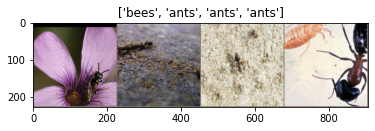

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [1]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

   # Creating array that will store the training and validation accuracy and loss
    train_accuracy =  np.zeros(num_epochs)
    train_loss =  np.zeros(num_epochs)

    valid_accuracy =  np.zeros(num_epochs)
    valid_loss =  np.zeros(num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #Checking if the phase is train or val. If the phase is train the train accuracy and loss arrays are updated
            #Likewise if the phase is val the valid accuracy and loss arrays are updated
            if phase == 'train':
              train_accuracy[epoch] = epoch_acc
              train_loss[epoch] = epoch_loss
            elif phase == 'val':
              valid_accuracy[epoch] = epoch_acc
              valid_loss[epoch] = epoch_loss

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #Plotting the Validation and Training loss
    plt.plot(np.arange(0,num_epochs,1),valid_loss,label='Validation Loss')
    plt.plot(np.arange(0,num_epochs,1),train_loss,label='Training Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Number of epochs')
    plt.ylabel('Validation loss')
    plt.legend()
    plt.show()

    #Plotting the Validation and training accuracy
    plt.plot(np.arange(0,num_epochs,1),valid_accuracy,label='Validation Accuracy')
    plt.plot(np.arange(0,num_epochs,1),train_accuracy,label='Training accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7057 Acc: 0.6598
val Loss: 0.2259 Acc: 0.9226

Epoch 1/24
----------
train Loss: 0.5587 Acc: 0.8033
val Loss: 0.2573 Acc: 0.9032

Epoch 2/24
----------
train Loss: 0.4959 Acc: 0.8033
val Loss: 0.9445 Acc: 0.6903

Epoch 3/24
----------
train Loss: 0.7345 Acc: 0.7459
val Loss: 0.4779 Acc: 0.8452

Epoch 4/24
----------
train Loss: 0.4767 Acc: 0.7910
val Loss: 0.2602 Acc: 0.9032

Epoch 5/24
----------
train Loss: 0.3692 Acc: 0.8443
val Loss: 0.3659 Acc: 0.8968

Epoch 6/24
----------
train Loss: 0.3353 Acc: 0.8852
val Loss: 0.3579 Acc: 0.8903

Epoch 7/24
----------
train Loss: 0.3166 Acc: 0.8607
val Loss: 0.3771 Acc: 0.8645

Epoch 8/24
----------
train Loss: 0.3689 Acc: 0.8238
val Loss: 0.3232 Acc: 0.8839

Epoch 9/24
----------
train Loss: 0.3984 Acc: 0.8484
val Loss: 0.3684 Acc: 0.8710

Epoch 10/24
----------
train Loss: 0.3168 Acc: 0.8689
val Loss: 0.3459 Acc: 0.8839

Epoch 11/24
----------
train Loss: 0.3896 Acc: 0.8361
val Loss: 0.3399 Acc: 0.8903

Epoch 12/24
----------
t

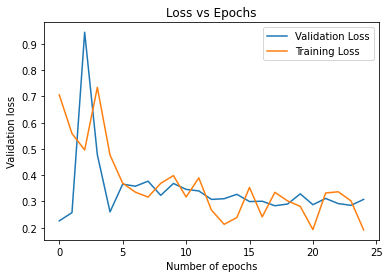

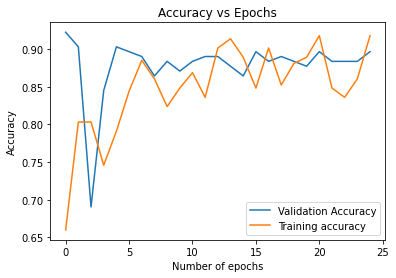

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


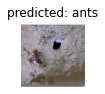

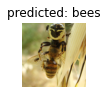

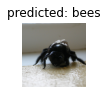

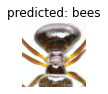

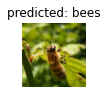

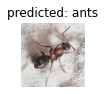

In [ ]:
visualize_model(model_ft)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3546 Acc: 0.8484
val Loss: 0.1724 Acc: 0.9226

Epoch 1/39
----------
train Loss: 0.3552 Acc: 0.8484
val Loss: 0.1911 Acc: 0.9161

Epoch 2/39
----------
train Loss: 0.4012 Acc: 0.8279
val Loss: 0.2134 Acc: 0.9290

Epoch 3/39
----------
train Loss: 0.3626 Acc: 0.8525
val Loss: 0.1916 Acc: 0.9226

Epoch 4/39
----------
train Loss: 0.3661 Acc: 0.8402
val Loss: 0.1830 Acc: 0.9226

Epoch 5/39
----------
train Loss: 0.3417 Acc: 0.8320
val Loss: 0.1824 Acc: 0.9226

Epoch 6/39
----------
train Loss: 0.4422 Acc: 0.7746
val Loss: 0.1836 Acc: 0.9161

Epoch 7/39
----------
train Loss: 0.4160 Acc: 0.8115
val Loss: 0.1847 Acc: 0.9226

Epoch 8/39
----------
train Loss: 0.3423 Acc: 0.8730
val Loss: 0.1872 Acc: 0.9226

Epoch 9/39
----------
train Loss: 0.3557 Acc: 0.8402
val Loss: 0.2037 Acc: 0.9226

Epoch 10/39
----------
train Loss: 0.4101 Acc: 0.8156
val Loss: 0.1843 Acc: 0.9161

Epoch 11/39
----------
train Loss: 0.3597 Acc: 0.8361
val Loss: 0.2071 Acc: 0.9161

Epoch 12/39
----------
t

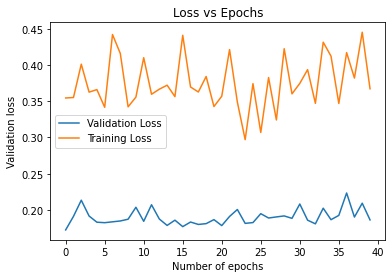

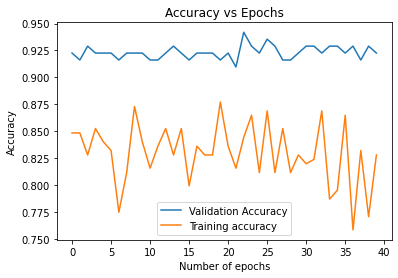

In [ ]:
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3855 Acc: 0.8197
val Loss: 0.1789 Acc: 0.9226

Epoch 1/49
----------
train Loss: 0.5061 Acc: 0.7541
val Loss: 0.1849 Acc: 0.9161

Epoch 2/49
----------
train Loss: 0.3660 Acc: 0.8402
val Loss: 0.1867 Acc: 0.9290

Epoch 3/49
----------
train Loss: 0.4253 Acc: 0.7951
val Loss: 0.1924 Acc: 0.9161

Epoch 4/49
----------
train Loss: 0.4457 Acc: 0.8074
val Loss: 0.1910 Acc: 0.9355

Epoch 5/49
----------
train Loss: 0.4569 Acc: 0.7910
val Loss: 0.1996 Acc: 0.9226

Epoch 6/49
----------
train Loss: 0.3937 Acc: 0.8238
val Loss: 0.1721 Acc: 0.9226

Epoch 7/49
----------
train Loss: 0.3914 Acc: 0.8279
val Loss: 0.1818 Acc: 0.9290

Epoch 8/49
----------
train Loss: 0.4369 Acc: 0.7787
val Loss: 0.1985 Acc: 0.9226

Epoch 9/49
----------
train Loss: 0.3660 Acc: 0.8402
val Loss: 0.1876 Acc: 0.9290

Epoch 10/49
----------
train Loss: 0.4111 Acc: 0.8238
val Loss: 0.1856 Acc: 0.9290

Epoch 11/49
----------
train Loss: 0.3570 Acc: 0.8238
val Loss: 0.1917 Acc: 0.9161

Epoch 12/49
----------
t

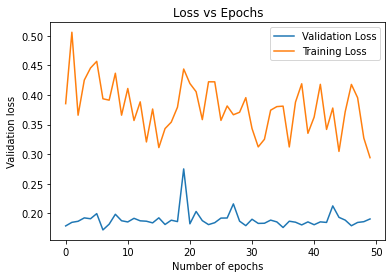

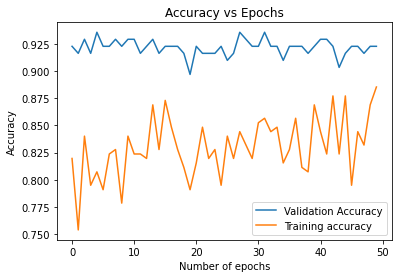

In [ ]:
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Discussion:

We have considered 3 different epochs with learning rate 0.001 and momentum 0.9 The best accuracy for epoch = 25 is 0.92 (approx), for epoch = 40 is 0.94(approx), for epoch = 50 is 0.935 (approx). It can be observed that there is not much difference in the best accuracy when the epch was varied. 

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.7622 Acc: 0.5451
val Loss: 53.0408 Acc: 0.5548

Epoch 1/24
----------
train Loss: 2.2235 Acc: 0.5082
val Loss: 1.5722 Acc: 0.5097

Epoch 2/24
----------
train Loss: 1.3178 Acc: 0.5369
val Loss: 1.3406 Acc: 0.5484

Epoch 3/24
----------
train Loss: 2.9484 Acc: 0.5205
val Loss: 1.5776 Acc: 0.5484

Epoch 4/24
----------
train Loss: 1.4474 Acc: 0.5984
val Loss: 0.9810 Acc: 0.4968

Epoch 5/24
----------
train Loss: 1.4100 Acc: 0.5369
val Loss: 2.4351 Acc: 0.4516

Epoch 6/24
----------
train Loss: 1.1216 Acc: 0.5369
val Loss: 1.4309 Acc: 0.4516

Epoch 7/24
----------
train Loss: 1.0286 Acc: 0.5533
val Loss: 0.8334 Acc: 0.4968

Epoch 8/24
----------
train Loss: 0.6972 Acc: 0.5533
val Loss: 0.8346 Acc: 0.5613

Epoch 9/24
----------
train Loss: 0.7125 Acc: 0.5738
val Loss: 0.7179 Acc: 0.5742

Epoch 10/24
----------
train Loss: 0.6951 Acc: 0.5779
val Loss: 0.6942 Acc: 0.5613

Epoch 11/24
----------
train Loss: 0.7062 Acc: 0.5574
val Loss: 0.7006 Acc: 0.5290

Epoch 12/24
----------


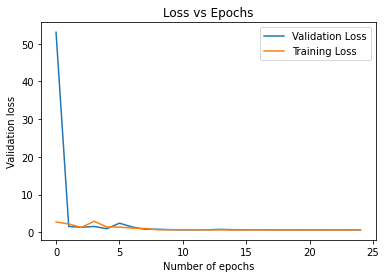

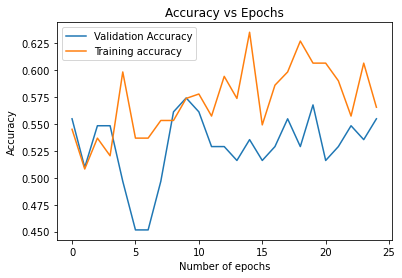

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6778 Acc: 0.6721
val Loss: 0.4927 Acc: 0.8065

Epoch 1/24
----------
train Loss: 0.6675 Acc: 0.7500
val Loss: 0.2916 Acc: 0.8710

Epoch 2/24
----------
train Loss: 0.6906 Acc: 0.7582
val Loss: 0.3464 Acc: 0.8774

Epoch 3/24
----------
train Loss: 0.4361 Acc: 0.8115
val Loss: 0.3391 Acc: 0.8710

Epoch 4/24
----------
train Loss: 0.4371 Acc: 0.8525
val Loss: 0.5194 Acc: 0.7742

Epoch 5/24
----------
train Loss: 0.5505 Acc: 0.7869
val Loss: 0.2647 Acc: 0.8839

Epoch 6/24
----------
train Loss: 0.4920 Acc: 0.8033
val Loss: 0.5464 Acc: 0.7484

Epoch 7/24
----------
train Loss: 0.4309 Acc: 0.7992
val Loss: 0.2460 Acc: 0.9161

Epoch 8/24
----------
train Loss: 0.3044 Acc: 0.8525
val Loss: 0.2245 Acc: 0.9226

Epoch 9/24
----------
train Loss: 0.2649 Acc: 0.8893
val Loss: 0.2165 Acc: 0.9226

Epoch 10/24
----------
train Loss: 0.2967 Acc: 0.8648
val Loss: 0.2193 Acc: 0.9097

Epoch 11/24
----------
train Loss: 0.3420 Acc: 0.8443
val Loss: 0.2192 Acc: 0.9290

Epoch 12/24
----------
t

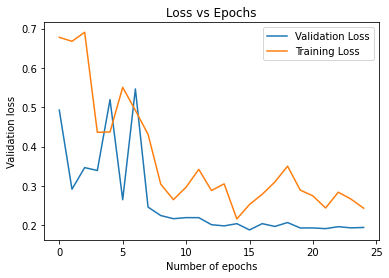

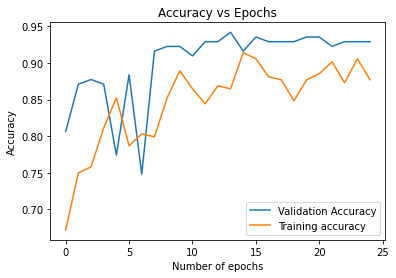

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6530 Acc: 0.6189
val Loss: 0.5161 Acc: 0.7613

Epoch 1/24
----------
train Loss: 0.5683 Acc: 0.6844
val Loss: 0.3705 Acc: 0.8774

Epoch 2/24
----------
train Loss: 0.4757 Acc: 0.8033
val Loss: 0.2991 Acc: 0.9032

Epoch 3/24
----------
train Loss: 0.4016 Acc: 0.8197
val Loss: 0.2488 Acc: 0.9290

Epoch 4/24
----------
train Loss: 0.4111 Acc: 0.8033
val Loss: 0.2241 Acc: 0.9484

Epoch 5/24
----------
train Loss: 0.4416 Acc: 0.7787
val Loss: 0.2168 Acc: 0.9484

Epoch 6/24
----------
train Loss: 0.3740 Acc: 0.8197
val Loss: 0.2337 Acc: 0.9226

Epoch 7/24
----------
train Loss: 0.3957 Acc: 0.8197
val Loss: 0.1992 Acc: 0.9419

Epoch 8/24
----------
train Loss: 0.3639 Acc: 0.8279
val Loss: 0.1902 Acc: 0.9484

Epoch 9/24
----------
train Loss: 0.3199 Acc: 0.8607
val Loss: 0.2081 Acc: 0.9355

Epoch 10/24
----------
train Loss: 0.3040 Acc: 0.8852
val Loss: 0.1997 Acc: 0.9484

Epoch 11/24
----------
train Loss: 0.3536 Acc: 0.8361
val Loss: 0.2300 Acc: 0.9290

Epoch 12/24
----------
t

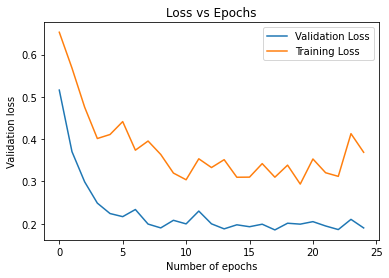

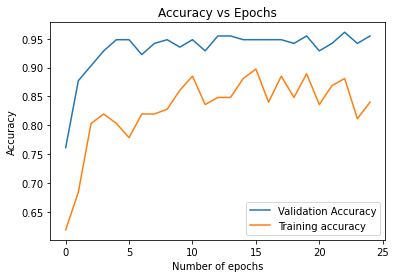

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Discussion:

We have considered 3 different learning rates(lr) [0.01,0.001,0.0001] with epoch 25 and momentum 0.9 The best accuracy for lr = 0.01 is 0.57 (approx), for lr = 0.001 is 0.94(approx), for lr = 0.0001 is 0.96 (approx). It can be observed that as the learning rate is reduced to 0.0001 with other parameters remaining constant we get an accuracy of 0.96 and when we increase the learning rate to 0.01 the accuracy reduces to 0.57

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6261 Acc: 0.6680
val Loss: 0.3859 Acc: 0.8710

Epoch 1/24
----------
train Loss: 0.4660 Acc: 0.7910
val Loss: 0.2619 Acc: 0.9355

Epoch 2/24
----------
train Loss: 0.3215 Acc: 0.8852
val Loss: 0.2134 Acc: 0.9290

Epoch 3/24
----------
train Loss: 0.3401 Acc: 0.8852
val Loss: 0.2059 Acc: 0.9290

Epoch 4/24
----------
train Loss: 0.3425 Acc: 0.8607
val Loss: 0.1960 Acc: 0.9290

Epoch 5/24
----------
train Loss: 0.3798 Acc: 0.8320
val Loss: 0.1961 Acc: 0.9226

Epoch 6/24
----------
train Loss: 0.3336 Acc: 0.8525
val Loss: 0.2001 Acc: 0.9548

Epoch 7/24
----------
train Loss: 0.3537 Acc: 0.8320
val Loss: 0.1909 Acc: 0.9484

Epoch 8/24
----------
train Loss: 0.3142 Acc: 0.8525
val Loss: 0.1870 Acc: 0.9484

Epoch 9/24
----------
train Loss: 0.3147 Acc: 0.8443
val Loss: 0.1814 Acc: 0.9226

Epoch 10/24
----------
train Loss: 0.4112 Acc: 0.7869
val Loss: 0.2083 Acc: 0.9161

Epoch 11/24
----------
train Loss: 0.3192 Acc: 0.8689
val Loss: 0.1894 Acc: 0.9355

Epoch 12/24
----------
t

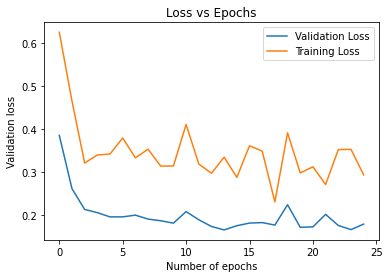

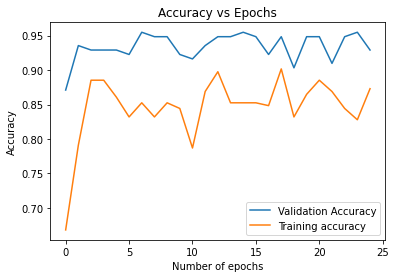

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6282 Acc: 0.6230
val Loss: 0.3370 Acc: 0.8839

Epoch 1/24
----------
train Loss: 0.3641 Acc: 0.8525
val Loss: 0.2203 Acc: 0.9419

Epoch 2/24
----------
train Loss: 0.3980 Acc: 0.7869
val Loss: 0.2719 Acc: 0.8839

Epoch 3/24
----------
train Loss: 0.3718 Acc: 0.8197
val Loss: 0.2375 Acc: 0.9032

Epoch 4/24
----------
train Loss: 0.4375 Acc: 0.7951
val Loss: 0.1844 Acc: 0.9355

Epoch 5/24
----------
train Loss: 0.3441 Acc: 0.8525
val Loss: 0.2648 Acc: 0.8968

Epoch 6/24
----------
train Loss: 0.3708 Acc: 0.8361
val Loss: 0.1651 Acc: 0.9484

Epoch 7/24
----------
train Loss: 0.2899 Acc: 0.8852
val Loss: 0.1858 Acc: 0.9419

Epoch 8/24
----------
train Loss: 0.3525 Acc: 0.8484
val Loss: 0.1883 Acc: 0.9419

Epoch 9/24
----------
train Loss: 0.2609 Acc: 0.8975
val Loss: 0.1863 Acc: 0.9484

Epoch 10/24
----------
train Loss: 0.3257 Acc: 0.8811
val Loss: 0.1828 Acc: 0.9484

Epoch 11/24
----------
train Loss: 0.2870 Acc: 0.8770
val Loss: 0.1800 Acc: 0.9419

Epoch 12/24
----------
t

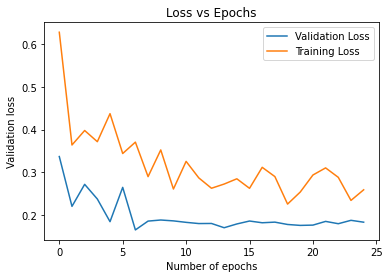

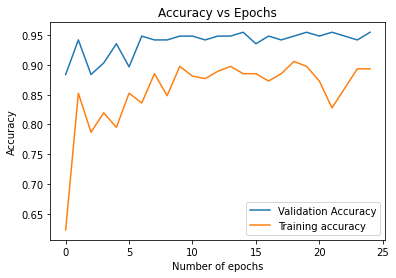

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.6)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5942 Acc: 0.7049
val Loss: 0.2876 Acc: 0.8903

Epoch 1/24
----------
train Loss: 0.6415 Acc: 0.7541
val Loss: 0.2956 Acc: 0.9097

Epoch 2/24
----------
train Loss: 0.4310 Acc: 0.8320
val Loss: 0.2254 Acc: 0.8968

Epoch 3/24
----------
train Loss: 0.8142 Acc: 0.7090
val Loss: 0.3494 Acc: 0.8968

Epoch 4/24
----------
train Loss: 0.4180 Acc: 0.8525
val Loss: 0.3544 Acc: 0.8903

Epoch 5/24
----------
train Loss: 0.5573 Acc: 0.7869
val Loss: 0.3216 Acc: 0.9097

Epoch 6/24
----------
train Loss: 0.4271 Acc: 0.8279
val Loss: 0.3039 Acc: 0.8774

Epoch 7/24
----------
train Loss: 0.4704 Acc: 0.8074
val Loss: 0.2388 Acc: 0.8968

Epoch 8/24
----------
train Loss: 0.3136 Acc: 0.8770
val Loss: 0.1917 Acc: 0.9097

Epoch 9/24
----------
train Loss: 0.3391 Acc: 0.8484
val Loss: 0.2166 Acc: 0.8968

Epoch 10/24
----------
train Loss: 0.2525 Acc: 0.9016
val Loss: 0.2081 Acc: 0.9032

Epoch 11/24
----------
train Loss: 0.2063 Acc: 0.9016
val Loss: 0.2067 Acc: 0.8968

Epoch 12/24
----------
t

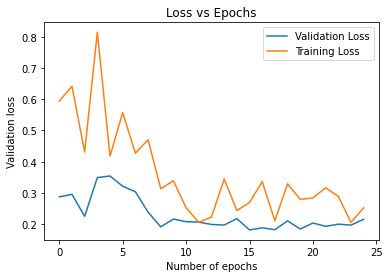

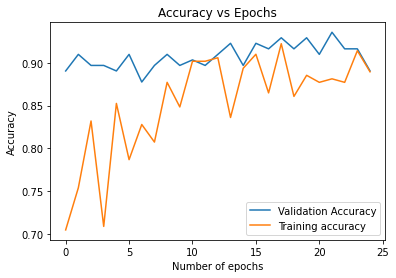

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Discussion:

We have considered 3 different momentum [0.5,0.6,0.9] with learning rate 0.001 and epoch 25 The best accuracy for momentum = 0.5 is 0.954 (approx), for momentum = 0.6 is 0.954(approx), for momentum = 0.9 is 0.935 (approx). There is not much difference when the momentum is varied